# Houghova transformace

Vstup: obraz

Výstup: pozice hledaných objektu

Cíl: nalézt v obraze objekty popsané mat. funkcí

![lines](http://www.kky.zcu.cz/uploads/courses/zdo/lesson9/vstup1.jpg)
![edges](http://www.kky.zcu.cz/uploads/courses/zdo/lesson9/edge1.jpg)

In [2]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


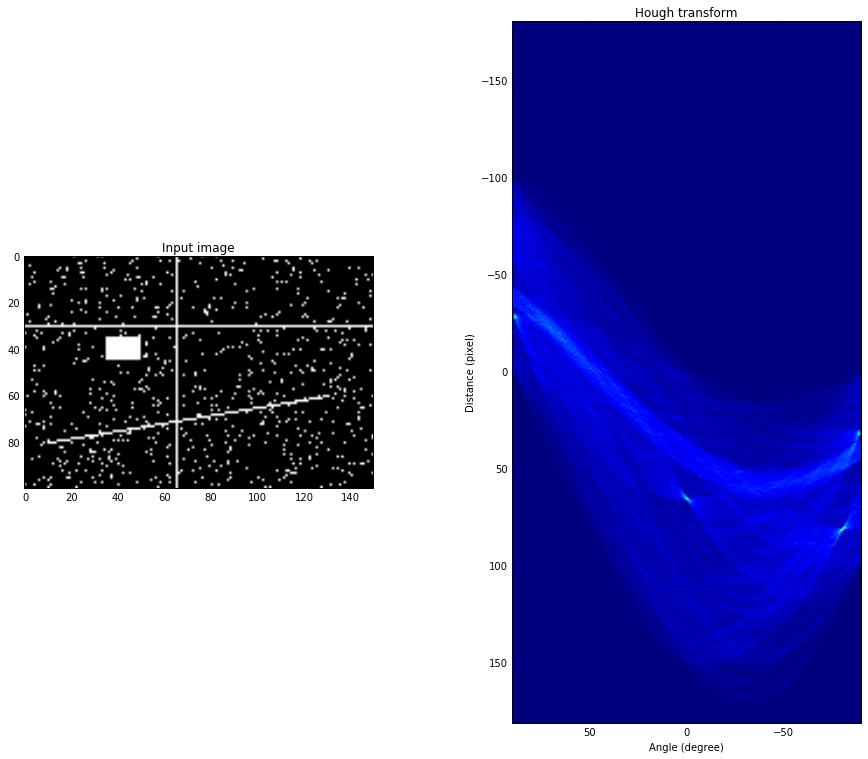

In [4]:
import skimage
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import hough_line
from skimage.draw import line

img = np.zeros((100, 150), dtype=bool)
img[30, :] = 1
img[:, 65] = 1
img[35:45, 35:50] = 1
rr, cc = line(60, 130, 80, 10)
img[rr, cc] = 1
img += np.random.random(img.shape) > 0.95

hspace, angles, dists = hough_line(img)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)

plt.imshow(img, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(1, 2, 2)
plt.imshow(hspace, 
#            cmap=plt.cm.bone,
           extent=(np.rad2deg(angles[-1]), np.rad2deg(angles[0]),
                   dists[-1], dists[0]))
plt.title('Hough transform')
plt.xlabel('Angle (degree)')
plt.ylabel('Distance (pixel)')

plt.subplots_adjust(wspace=0.4)
plt.show()

Nalezení vrcholů v Houghově transformaci

[dokumentace k hough_line_peaks](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_line_peaks)

In [26]:
#from skimage.transform import hough_peaks

#d#ir(skimage.transform)


lhspace, langles, ldists = skimage.transform.hough_line_peaks(hspace, angles, dists)
print lhspace
print langles
print ldists



[150  91]
[-1.57079633  1.41283915]
[-29.58171745  80.72299169]


/home/mjirik/miniconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:40: skimage_deprecation: Call to deprecated function ``canny``. Use ``skimage.feature.canny`` instead.
  def canny(*args, **kwargs):


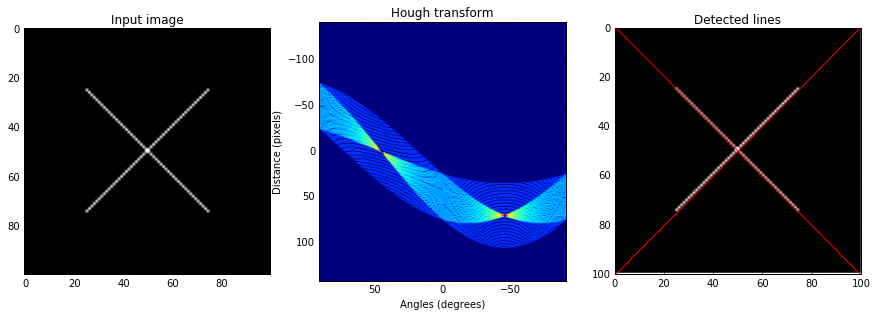

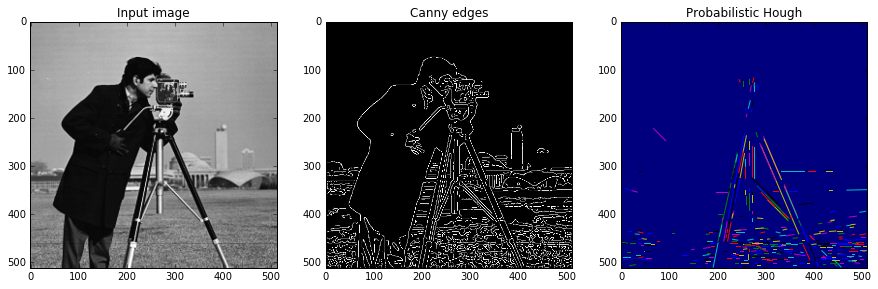

In [8]:

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.filter import canny
from skimage import data

import numpy as np
import matplotlib.pyplot as plt

# Construct test image

image = np.zeros((100, 100))


# Classic straight-line Hough transform

idx = np.arange(25, 75)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

h, theta, d = hough_line(image)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(image, 
           cmap=plt.cm.gray
          )
plt.title('Input image')

plt.subplot(132)
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
#            cmap=plt.cm.gray, 
           aspect=1/1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

plt.subplot(133)
plt.imshow(image, cmap=plt.cm.gray)
rows, cols = image.shape
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')

# Line finding, using the Probabilistic Hough Transform

image = data.camera()
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=100, line_length=5, line_gap=3)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(132)
plt.imshow(edges, 
           cmap=plt.cm.gray
          )
plt.title('Canny edges')

plt.subplot(133)
plt.imshow(edges * 0)

for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

plt.title('Probabilistic Hough')
plt.axis('image')
plt.show()

## Kruhová Houghova transformace

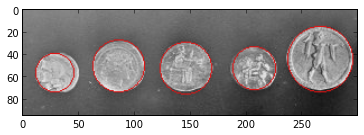

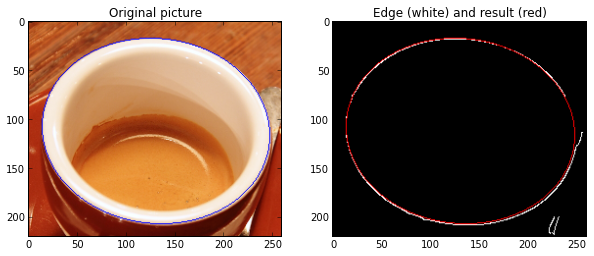

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, filter, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
image = img_as_ubyte(data.coins()[0:95, 70:370])
edges = filter.canny(image, sigma=3, low_threshold=10, high_threshold=50)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))

# Detect two radii
hough_radii = np.arange(15, 30, 2)
hough_res = hough_circle(edges, hough_radii)

centers = []
accums = []
radii = []

for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract two circles
    peaks = peak_local_max(h, num_peaks=2)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius, radius])

# Draw the most prominent 5 circles
image = color.gray2rgb(image)
for idx in np.argsort(accums)[::-1][:5]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)


"""
Ellipse detection
=================

In this second example, the aim is to detect the edge of a coffee cup.
Basically, this is a projection of a circle, i.e. an ellipse.
The problem to solve is much more difficult because five parameters have to be
determined, instead of three for circles.


Algorithm overview
------------------

The algorithm takes two different points belonging to the ellipse. It assumes
that it is the main axis. A loop on all the other points determines how much
an ellipse passes to them. A good match corresponds to high accumulator values.

A full description of the algorithm can be found in reference [1]_.

References
----------
.. [1] Xie, Yonghong, and Qiang Ji. "A new efficient ellipse detection
       method." Pattern Recognition, 2002. Proceedings. 16th International
       Conference on. Vol. 2. IEEE, 2002
"""

import matplotlib.pyplot as plt

from skimage import data, filter, color
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges
image_rgb = data.coffee()[0:220, 160:420]
image_gray = color.rgb2gray(image_rgb)
edges = filter.canny(image_gray, sigma=2.0,
                     low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = hough_ellipse(edges, accuracy=20, threshold=250,
                       min_size=100, max_size=120)
result.sort(order='accumulator')

# Estimated parameters for the ellipse
best = result[-1]
yc = int(best[1])
xc = int(best[2])
a = int(best[3])
b = int(best[4])
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(edges)
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 6))

ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

# Zpětná projekce

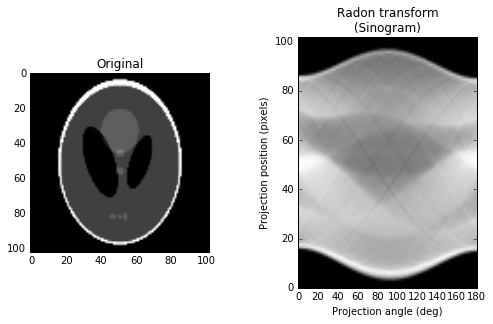

In [3]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import data_dir
from skimage.transform import radon, rescale

image = imread("http://www.damtp.cam.ac.uk/user/cbs31/webpage_tvdode/phantom.png", as_grey=True)
image = rescale(image, scale=0.4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.subplots_adjust(hspace=0.4, wspace=0.5)
plt.show()

FBP rms reconstruction error: 0.0547


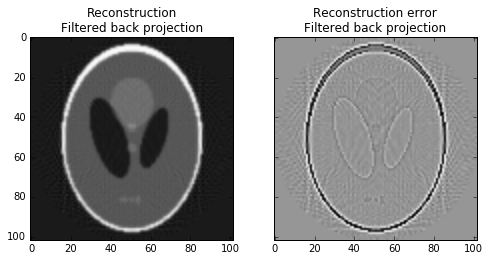

In [4]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image
print('FBP rms reconstruction error: %.3g' % np.sqrt(np.mean(error**2)))

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

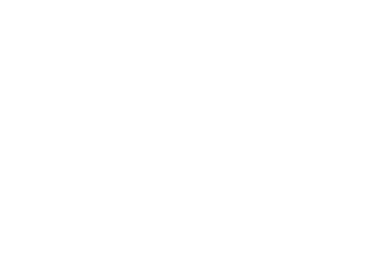

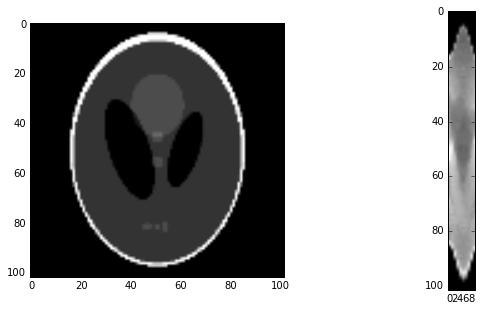

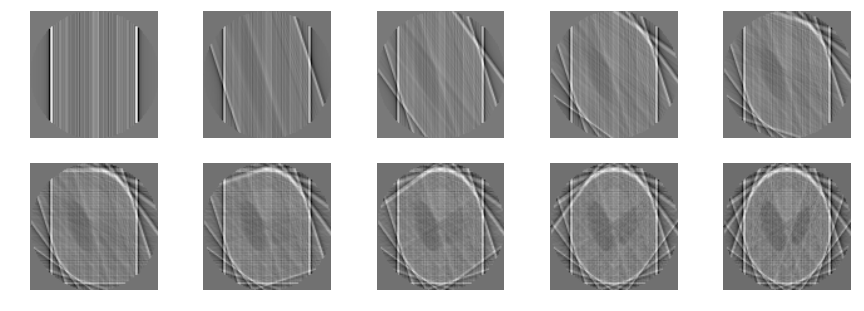

In [24]:
kolik = 10
theta = np.linspace(0., 180., kolik , endpoint=False)
# theta = [0, 45, 90]
sinogram = radon(image, theta=theta, circle=True)
reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)

plt.axis('off')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image, cmap='gray')
ax2.imshow(sinogram, cmap='gray')
plt.figure(figsize=(15,5))
plt.axis('off')
for i in range(1, kolik+1):
    plt.subplot(2,kolik / 2,i)
    plt.axis('off')
    reconstruction_fbp = iradon(sinogram[:,:i], theta=theta[:i], circle=True)
    

    plt.imshow(reconstruction_fbp, cmap='gray')

# 3D vidění

[epipolární geometrie](http://www.elektrorevue.cz/clanky/05017/index.html)